# Testing Sentinel-1 SLC Burst Extraction from Remote Zipped and Unpacked .SAFE Scenes

The code processes subswath TIFF files to determine burst size and extract individual bursts. Bursts typically have around 1,500 pixels in the azimuthal direction, and their total number is an integer, allowing for exact burst count calculation. Additionally, the burst sizes are specified in supplementary XML files, which are parsed using the PyGMTSAR ASF module. For production purposes, extracting sizes from the TIFF files is unnecessary. However, this code is designed to test remote TIFF analysis and extraction capabilities.


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from dask.distributed import Client
import dask
import s3fs
from tifffile import TiffFile
import rasterio
import zipfile

In [2]:
# This key was functional at the time of testing the notebook.
# I cannot use the account for any practical purposes due to the ridiculous speed limitations on ESA storage.
endpoint_url = 'https://eodata.dataspace.copernicus.eu/'
access_key = '9XXR4MT7F4NC7JJE5B2W'
secret_key = 'HwgD8jHfzT3noPNRHdDPJV478wt8TWuCgyU9DlR3'

## Singapore Archive (Zipped Scenes)

https://registry.opendata.aws/sentinel1-slc-seasia-pds/

In [3]:
zip_file = 's3://sentinel1-slc-seasia-pds/datasets/slc/v1.1/2024/04/04/S1A_IW_SLC__1SDV_20240404T225022_20240404T225040_053290_0675B9_CAD3/\
S1A_IW_SLC__1SDV_20240404T225022_20240404T225040_053290_0675B9_CAD3.zip'
tiff_filename = 'S1A_IW_SLC__1SDV_20240404T225022_20240404T225040_053290_0675B9_CAD3.SAFE/measurement/s1a-iw3-slc-vv-20240404t225023-20240404t225040-053290-0675b9-006.tiff'

In [4]:
%%time

s3 = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': 'https://s3.ap-southeast-1.amazonaws.com'})

with s3.open(zip_file, mode='rb') as s3_file:
    with zipfile.ZipFile(s3_file, mode='r') as z:
        assert tiff_filename in z.namelist()
        with z.open(tiff_filename) as tiff_file:
            with TiffFile(tiff_file) as tif:
                page = tif.pages[0]
                offset = page.dataoffsets[0]
                print(f'Image size: {page.imagewidth} x {page.imagelength}')
                print(f'Data first offset: {offset}')
                bursts = int(np.round(page.imagelength / 1500))
                print(f'Bursts number: {bursts}')
                burst_size = page.imagelength // bursts
                print(f'Bursts size: {burst_size}')

# Image size: 23935 x 9030
# Data first offset: 72555
# Bursts number: 6
# Bursts size: 1505
# CPU times: user 1min 16s, sys: 27.5 s, total: 1min 43s
# Wall time: 9min 26s

Image size: 23935 x 9030
Data first offset: 72555
Bursts number: 6
Bursts size: 1505
CPU times: user 1min 14s, sys: 26.9 s, total: 1min 41s
Wall time: 11min 7s


In [5]:
# specify to open TiFF file in remote zip achrive
zip_file = '/vsizip/vsicurl/https://sentinel1-slc-seasia-pds.s3-ap-southeast-1.amazonaws.com/datasets/slc/v1.1/2024/04/04/\
S1A_IW_SLC__1SDV_20240404T225022_20240404T225040_053290_0675B9_CAD3/S1A_IW_SLC__1SDV_20240404T225022_20240404T225040_053290_0675B9_CAD3.zip'
#tiff_filename = 'S1A_IW_SLC__1SDV_20240404T225022_20240404T225040_053290_0675B9_CAD3.SAFE/measurement/s1a-iw3-slc-vv-20240404t225023-20240404t225040-053290-0675b9-006.tiff'
tiff_filepath = f"{zip_file}/{tiff_filename}"
# apply the burst size calculated above
burst_size = 1505

CPU times: user 1.86 s, sys: 2.51 s, total: 4.37 s
Wall time: 32.5 s


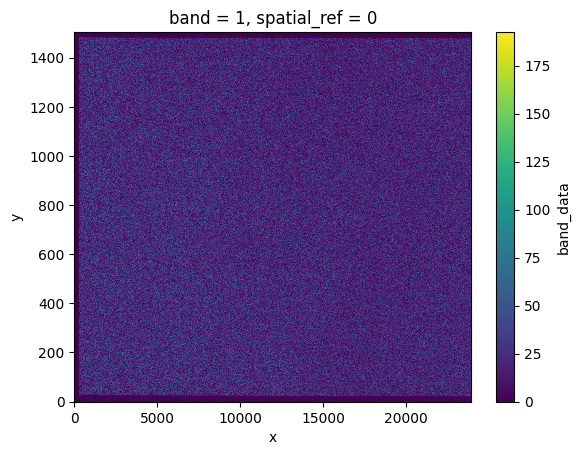

In [6]:
%%time
# approach 1
with rasterio.open(tiff_filepath) as dataset:
    data = xr.open_dataset(dataset, engine='rasterio').chunk({'y': burst_size, 'x': -1})
    np.abs(data.band_data[0, :burst_size, :]).plot.imshow()

# CPU times: user 1.72 s, sys: 2.09 s, total: 3.8 s
# Wall time: 37.2 s

CPU times: user 1.45 s, sys: 2.42 s, total: 3.86 s
Wall time: 34.7 s


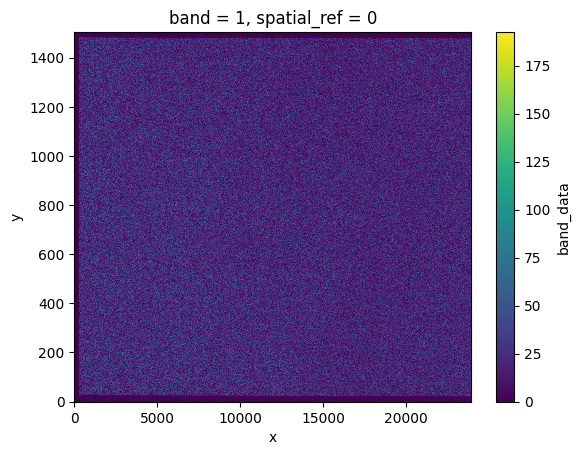

In [7]:
%%time
# approach 2
data = xr.open_dataset(tiff_filepath, engine='rasterio').chunk({'y': burst_size, 'x': -1})
np.abs(data.band_data[0, :burst_size, :]).plot.imshow()

# CPU times: user 1.37 s, sys: 2.21 s, total: 3.58 s
# Wall time: 26.3 s

## Germany Archive (Scenes)

https://registry.opendata.aws/sentinel1-slc/

aws s3 ls --no-sign-request --region eu-west-1 s3://sentinel1-slc/2022/12/08/S1A_IW_SLC__1SDV_20221208T165321_20221208T165349_046243_05898B_6BD6.SAFE/measurement/s1a-iw3-slc-vv-20221208t165323-20221208t165349-046243-05898b-006.tiff 
2022-12-09 23:12:25 1402829300 s1a-iw3-slc-vv-20221208t165323-20221208t165349-046243-05898b-006.tiff

In [8]:
tiff_file = 's3://sentinel1-slc/2022/12/08/S1A_IW_SLC__1SDV_20221208T165321_20221208T165349_046243_05898B_6BD6.SAFE/measurement/\
s1a-iw3-slc-vv-20221208t165323-20221208t165349-046243-05898b-006.tiff'

Image size: 25683 x 13653
Data first offset: 109539
Bursts number: 9
Bursts size: 1517
CPU times: user 5.05 s, sys: 1.99 s, total: 7.04 s
Wall time: 54.7 s


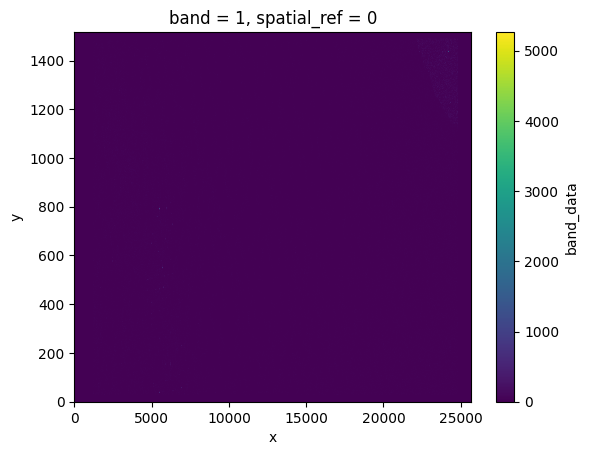

In [9]:
%%time

s3 = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': 'https://s3.eu-west-1.amazonaws.com'})

with s3.open(tiff_file, mode='rb') as s3_file:
    with TiffFile(s3_file) as tif:
        page = tif.pages[0]
        offset = page.dataoffsets[0]
        print(f'Image size: {page.imagewidth} x {page.imagelength}')
        print(f'Data first offset: {offset}')
        bursts = int(np.round(page.imagelength / 1500))
        print(f'Bursts number: {bursts}')
        burst_size = page.imagelength // bursts
        print(f'Bursts size: {burst_size}')

with s3.open(tiff_file, mode='rb') as s3_file:
    data = xr.open_dataset(s3_file, engine='rasterio').chunk({'y': burst_size, 'x': -1})
    np.abs(data.band_data[0, :burst_size, :]).plot.imshow()

# Image size: 25683 x 13653
# Data first offset: 109539
# Bursts number: 9
# Bursts size: 1517
# CPU times: user 4.62 s, sys: 1.79 s, total: 6.42 s
# Wall time: 48.5 s

## ESA Archive (Scenes)

https://eodata-s3keysmanager.dataspace.copernicus.eu/panel/s3-credentials

https://documentation.dataspace.copernicus.eu/APIs/S3.html#accessing-eodata-via-aws-cli

https://documentation.dataspace.copernicus.eu/APIs/openEO/openeo-community-examples/python/OilSpill/OilSpillMapping.html

https://documentation.dataspace.copernicus.eu/APIs/STAC.html

In [10]:
tiff_filename = 's3://eodata/Sentinel-1/SAR/SLC/2022/12/31/S1A_IW_SLC__1SDV_20221231T100618_20221231T100646_046574_0594DE_18E0.SAFE/measurement/\
s1a-iw1-slc-vh-20221231t100618-20221231t100646-046574-0594de-001.tiff'

In [11]:
%%time

s3 = s3fs.S3FileSystem(key=access_key, secret=secret_key, 
                       client_kwargs={'endpoint_url': endpoint_url})
with s3.open(tiff_filename, mode='rb') as file:
    data = xr.open_dataset(file, engine='rasterio').chunk(2048)
data

# CPU times: user 172 ms, sys: 78.7 ms, total: 251 ms
# Wall time: 5.2 s

Exception ignored in: <function ThreadURIManager.__del__ at 0x15f0ea020>
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/rioxarray/_io.py", line 231, in __del__
ERROR 3: /vsipythonfilelike/4cd7820e-cf5c-4ca1-a90c-4a5a6c48df47/4cd7820e-cf5c-4ca1-a90c-4a5a6c48df47: I/O error
    self.close()
  File "/opt/homebrew/lib/python3.11/site-packages/rioxarray/_io.py", line 227, in close
    self._file_handle.close()
  File "rasterio/_base.pyx", line 441, in rasterio._base.DatasetBase.close
  File "/opt/homebrew/Cellar/python@3.11/3.11.9_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py", line 609, in close
    self.__exit__(None, None, None)
  File "/opt/homebrew/Cellar/python@3.11/3.11.9_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py", line 563, in __exit__
    frame_exc = sys.exc_info()[1]
                ^^^^^^^^^^^^^^
SystemError: <built-in function exc_info> returned a result with an exception set


CPU times: user 212 ms, sys: 85.2 ms, total: 297 ms
Wall time: 4.43 s


<xarray.Dataset> Size: 2GB
Dimensions:      (band: 1, y: 14900, x: 20554)
Coordinates:
  * band         (band) int64 8B 1
    spatial_ref  int64 8B ...
Dimensions without coordinates: y, x
Data variables:
    band_data    (band, y, x) complex64 2GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

Image size: 20554 x 14900
Data first offset: 119515
Bursts number: 10
Bursts size: 1490
CPU times: user 4.07 s, sys: 1.59 s, total: 5.65 s
Wall time: 41.6 s


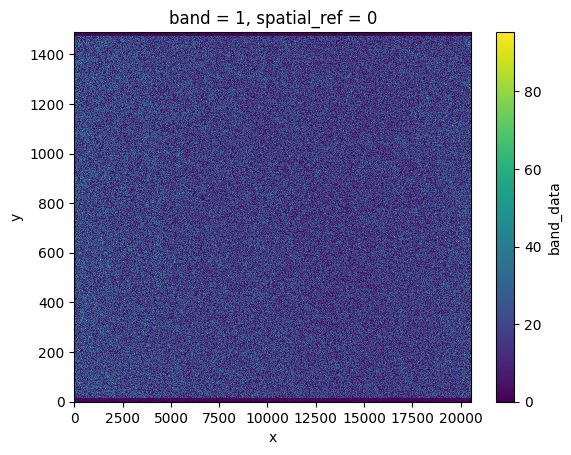

In [12]:
%%time
s3 = s3fs.S3FileSystem(key=access_key, secret=secret_key, 
                       client_kwargs={'endpoint_url': endpoint_url})
with s3.open(tiff_filename, mode='rb') as s3_file:
    with TiffFile(s3_file) as tif:
        page = tif.pages[0]
        offset = page.dataoffsets[0]
        print(f'Image size: {page.imagewidth} x {page.imagelength}')
        print(f'Data first offset: {offset}')
        bursts = int(np.round(page.imagelength / 1500))
        print (f'Bursts number: {bursts}')
        burst_size = page.imagelength // bursts
        print (f'Bursts size: {burst_size}')
with s3.open(tiff_filename, mode='rb') as s3_file:
    data = xr.open_dataset(file, engine='rasterio').chunk({'y': burst_size, 'x': -1})
    np.abs(data.band_data[0,:burst_size,:]).plot.imshow()

# Image size: 20554 x 14900
# Data first offset: 119515
# Bursts number: 10
# Bursts size: 1490
# CPU times: user 3.37 s, sys: 1.35 s, total: 4.72 s
# Wall time: 44.1 s